
*Training model for feature - glasses*



*Importing all necessary libraries*


In [1]:
import pandas as pd
import numpy as np
from os import listdir
import cv2 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
%matplotlib inline
from numpy import expand_dims
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Model
from tensorflow import keras

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [ ]:
*Importing all the images which will be used for training*

A sample file name: unsplash_100233.jpg
Shape information of two arbitrary images: (64, 64, 3) - this one is shown below, and (533, 800, 3)


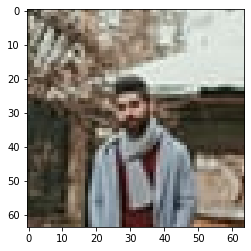

In [2]:
dir_struct = 'C:/Users/wania/Desktop/Coursework_1/images/'
file_lst = listdir(dir_struct) # it will return all the image file names as a list
print('A sample file name: {}'.format(file_lst[1]))

# Change color to RGB from OpenCV's BGR format since this library uses BGR format [rather than RGB] for historical purposes
# an interesting perspective on why OpenCV uses BGR : https://learnopencv.com/why-does-opencv-use-bgr-color-format/
image = cv2.imread(dir_struct+file_lst[1])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('Shape information of two arbitrary images: {} - this one is shown below, and {}'.format(image.shape, cv2.imread(dir_struct+file_lst[5]).shape))
plt.imshow(image)

*Importing csv file which contains annotations and creating a dataframe*

In [3]:
df  = pd.read_csv('C:/Users/wania/Desktop/Coursework_1/annotations.csv')
print('Number of images: ', df.shape[0])
print('The proportion of the different glasses labels: ')
# you may see equal proportion: logical since we have randomly assigned the label
df.glasses.value_counts()

Number of images:  1000
The proportion of the different glasses labels: 


0    859
1     82
2     59
Name: glasses, dtype: int64

*Creating a new column which will hold all the images as arrays*

,image_name,wrinkles,freakles,glasses,hair_color,hair_top,no_face_shown,image
0,unsplash_612.jpg,0,0,1,0,2,0,"[[[52, 59, 52], [52, 58, 51], [56, 59, 49], [6..."
1,unsplash_952.jpg,0,1,0,1,2,0,"[[[105, 127, 100], [106, 128, 101], [107, 129,..."
2,unsplash_984.jpg,0,0,0,1,2,0,"[[[184, 61, 75], [190, 63, 80], [195, 66, 86],..."
3,unsplash_1003.jpg,0,0,0,3,2,0,"[[[186, 224, 243], [187, 226, 246], [190, 228,..."
4,unsplash_1092.jpg,0,0,0,8,3,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


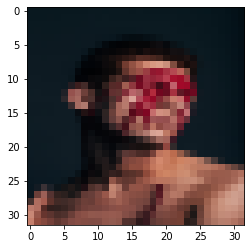

In [4]:
image_lst = [] # this list will hold all the images
#for i in range(1):
for i in range(df.shape[0]): # read the image one by one
    image = cv2.imread(dir_struct+df.iloc[i]['image_name'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB convert
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) # resizing all images to 32x32: NOT ideal but need to be uniform in order to apply the algorithm
                                                                                                                        # this actually ensures all the features [pixel values] will be of same size
    image_lst.append(image) # appending the read image to a list

df['image'] = image_lst # creating a new column that holds all the images
# showing the same image that we have displayed before
# see the change because of resizing
plt.imshow(df.iloc[5]['image'])
df.head(5)

*Splitting the dataset into train and test*

In [5]:
X = df.drop(['image_name','wrinkles','freakles','glasses','hair_color','hair_top','no_face_shown'], axis=1)
y = df['glasses']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y, random_state=42)

In [9]:
print('Training dataset shape: {}'.format(X_train.shape))
print('Testing dataset shape: {}'.format(X_test.shape))
print('Training dataset shape: {}'.format(y_train.shape))
print('Testing dataset shape: {}'.format(y_test.shape))

print(X_train.head(10))

print(y_train.head(2))

Training dataset shape: (700, 1)
Testing dataset shape: (300, 1)
Training dataset shape: (700,)
Testing dataset shape: (300,)
                                                 image
634  [[[79, 72, 63], [122, 121, 122], [147, 148, 15...
467  [[[69, 181, 200], [5, 172, 196], [1, 165, 193]...
862  [[[182, 192, 204], [181, 191, 205], [185, 195,...
622  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
29   [[[22, 14, 8], [23, 13, 7], [27, 14, 8], [30, ...
450  [[[9, 9, 9], [6, 6, 6], [3, 3, 3], [1, 1, 1], ...
530  [[[51, 51, 51], [52, 52, 52], [51, 51, 51], [5...
191  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
833  [[[25, 15, 22], [14, 5, 8], [19, 11, 9], [9, 4...
826  [[[154, 154, 154], [158, 158, 158], [161, 161,...
634    0
467    0
Name: glasses, dtype: int64


Converting images to (32,32,3) and using normalization

In [10]:
# manually converting it to the similar shape as our other example
X_train['image'] = X_train['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])
X_test['image'] = X_test['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])

X_train = np.reshape([x for x in X_train['image'].values], (X_train.shape[0], 32, 32, 3))
X_test = np.reshape([x for x in X_test['image'].values], (X_test.shape[0], 32, 32, 3))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range)
X_train /= 255
X_test /= 255

<ipython-input-10-639a2418b2f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['image'] = X_train['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])
<ipython-input-10-639a2418b2f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['image'] = X_test['image'].apply(lambda x:x.reshape(1, 32, 32, 3)[0])


In [11]:
print('Converted training dataset shape: {}'.format(X_train.shape))
print('Converted Testing dataset shape: {}'.format(X_test.shape))

Converted training dataset shape: (700, 32, 32, 3)
Converted Testing dataset shape: (300, 32, 32, 3)


In [12]:
model = models.Sequential()

model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", input_shape=(32,32,3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))  ## END BLOCK 1
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))   ## END BLOCK 2
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 3 
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 4 
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))    ## END BLOCK 5 
model.add(layers.Flatten())    ## converting to vector 
model.add(layers.Dense(4096, activation="relu"))    ## 1st FC layer 
model.add(layers.Dense(4096, activation="relu"))    ## 2st FC layer 
model.add(layers.Dense(10, activation="softmax"))    ## output layer 




model.compile(optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

Epoch 1/10
2/2 [==============================] - 32s 10s/step - loss: 2.3016 - accuracy: 0.1495 - val_loss: 2.2784 - val_accuracy: 0.8600
Epoch 2/10
2/2 [==============================] - 28s 8s/step - loss: 2.2706 - accuracy: 0.8588 - val_loss: 2.1171 - val_accuracy: 0.8600
Epoch 3/10
2/2 [==============================] - 28s 8s/step - loss: 2.0690 - accuracy: 0.8601 - val_loss: 1.2890 - val_accuracy: 0.8600
Epoch 4/10
2/2 [==============================] - 27s 8s/step - loss: 1.2102 - accuracy: 0.8608 - val_loss: 1.0739 - val_accuracy: 0.8600
Epoch 5/10
2/2 [==============================] - 26s 8s/step - loss: 1.1177 - accuracy: 0.8582 - val_loss: 0.8329 - val_accuracy: 0.8600
Epoch 6/10
2/2 [==============================] - 26s 8s/step - loss: 0.8385 - accuracy: 0.8595 - val_loss: 0.7366 - val_accuracy: 0.8600
Epoch 7/10
2/2 [==============================] - 26s 8s/step - loss: 0.7544 - accuracy: 0.8608 - val_loss: 0.8165 - val_accuracy: 0.8600
Epoch 8/10
2/2 [=================

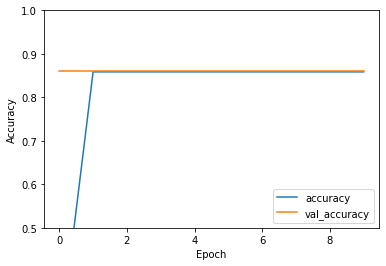

In [13]:
# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                    validation_data=(X_test, y_test))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

Epoch 1/50
22/22 [==============================] - 31s 1s/step - loss: 0.5651 - accuracy: 0.8586 - val_loss: 0.5333 - val_accuracy: 0.8600
Epoch 2/50
22/22 [==============================] - 30s 1s/step - loss: 0.5506 - accuracy: 0.8586 - val_loss: 0.5184 - val_accuracy: 0.8600
Epoch 3/50
22/22 [==============================] - 31s 1s/step - loss: 0.5461 - accuracy: 0.8586 - val_loss: 0.5109 - val_accuracy: 0.8600
Epoch 4/50
22/22 [==============================] - 30s 1s/step - loss: 0.5676 - accuracy: 0.8586 - val_loss: 0.5210 - val_accuracy: 0.8600
Epoch 5/50
22/22 [==============================] - 31s 1s/step - loss: 0.5337 - accuracy: 0.8586 - val_loss: 0.5608 - val_accuracy: 0.8600
Epoch 6/50
22/22 [==============================] - 31s 1s/step - loss: 0.5422 - accuracy: 0.8586 - val_loss: 0.5330 - val_accuracy: 0.8600
Epoch 7/50
22/22 [==============================] - 30s 1s/step - loss: 0.5456 - accuracy: 0.8586 - val_loss: 0.5269 - val_accuracy: 0.8600
Epoch 8/50
22/22 [==

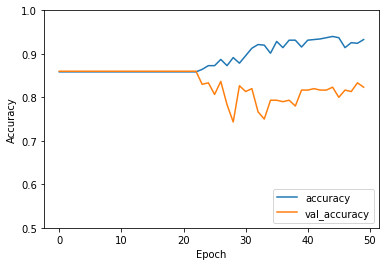

In [14]:
# Training
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test))

# Validation
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)

Model Predictions

In [15]:
predictions = model.predict(X_test)
predictions[0]

array([9.9997318e-01, 1.6328782e-05, 1.0481992e-05, 7.0957710e-23,
       8.4083914e-23, 5.5933810e-23, 1.1837845e-22, 2.7272130e-23,
       1.3179442e-23, 4.3765836e-23], dtype=float32)

In [16]:
predictions_index = np.argmax(predictions, axis=1) # Convert one-hot to index; remember indexing starts from 0; index takes integers values in [0,1]
predictions_index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], d